In [1]:
import numpy as np
import scipy.linalg as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from itertools import product

sns.set_style('whitegrid')

sns.set_context('notebook')

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 200

%load_ext autoreload
%autoreload 2

dev = 'cuda'

In [2]:
from utils import *
from embed import *

models = ["wr-4-8", "allcnn-96-144", "fc-1024-512-256-128"]
opts = ["adam", "sgdn", "sgd"]

In [3]:
T = 45000
ts = []
for t in range(T):
    if t < T//10:
        if t % (T//100) == 0:
            ts.append(t)
    else:
        if t % (T//10) == 0 or (t == T-1):
            ts.append(t)
ts = np.array(ts)
tmap = {i:ts[i] for i in range(len(ts))}
pts = np.concatenate([np.arange(ts[i], ts[i+1], (ts[i+1]-ts[i]) // 5) for i in range(len(ts)-1)])
N = len(pts)

## Bhat vs InPCA

In [5]:
loc = 'inpca_results'
fn = 'yh_new_interpolate_with_avg'
w = th.load(os.path.join(loc,'w_%s.p'%fn))
dc = th.load(os.path.join(loc,'didx_%s.p'%fn)).reset_index()

l = np.eye(w.shape[0]) - 1.0/w.shape[0]
w = -l @ w @ l 
n = len(w)
r = proj_(w, n, 500)

Projecting


In [8]:
loc = 'results/models/new'
d = load_d(loc, cond={'bs':[200], 'aug':[True], 'wd':[0.0], 'bn':[True], 'm':models, 'opt':opts},
           avg_err=True, drop=True, probs=True)

d = avg_model(d, groupby=['m', 'opt', 't'], probs=True, get_err=True, 
              update_d=True, compute_distance=False, dev='cuda')['d']
d = interpolate(d, ts, pts, columns=['seed', 'm', 'opt', 'avg'], keys=['yh', 'yvh'], dev='cuda')

Index(['index', 'seed', 'm', 'opt', 'lr', 'wd', 'bn', 'aug', 'bs', 't', 'yh',
       'f', 'e', 'yvh', 'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 1800


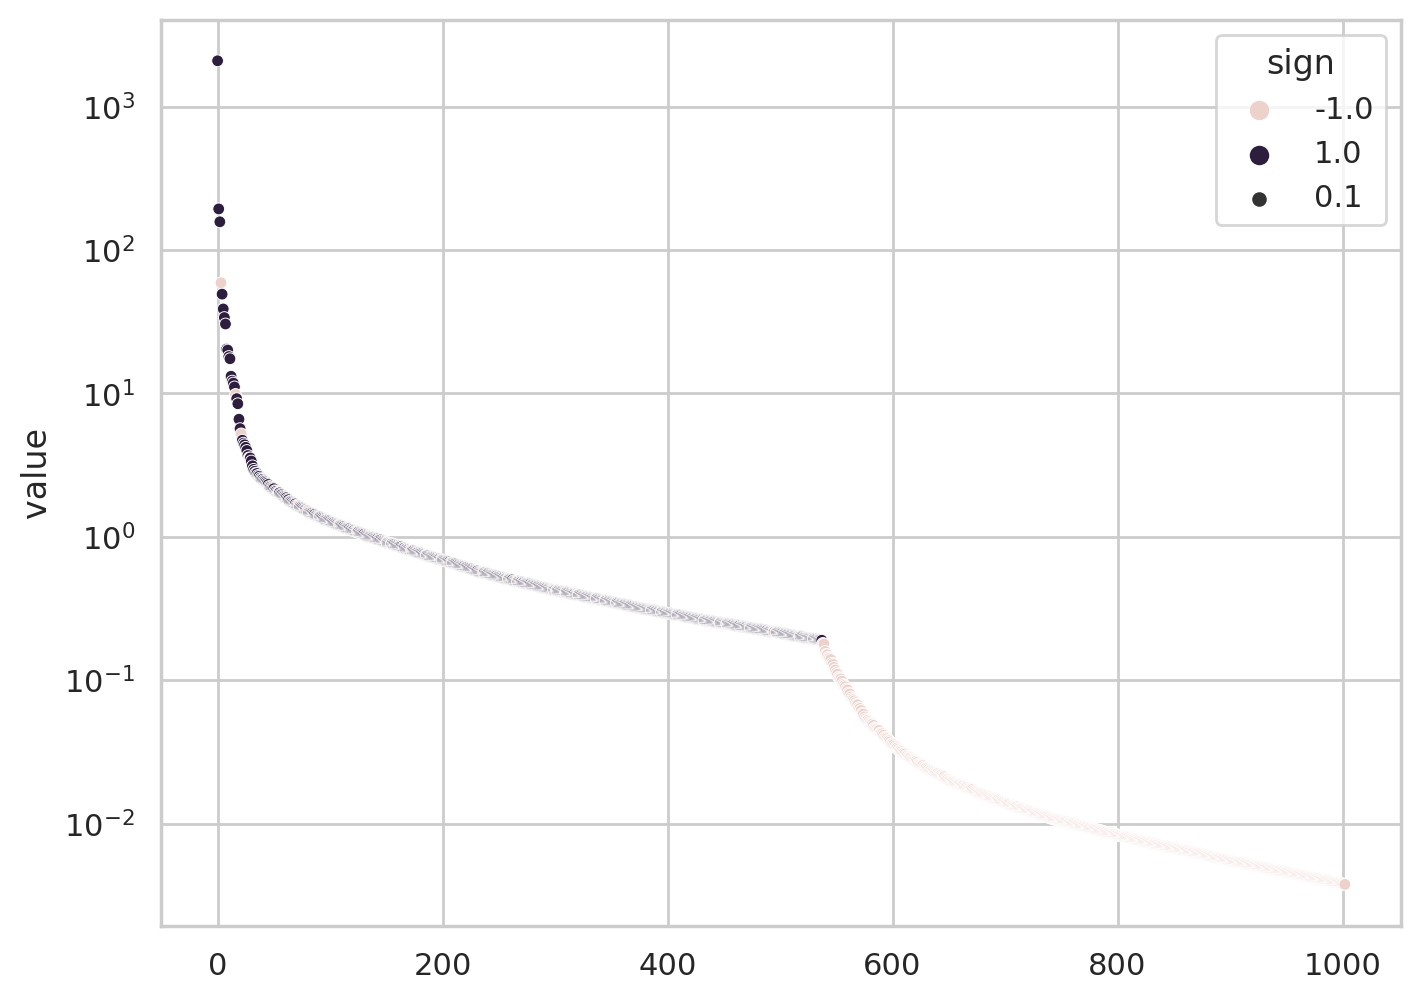

In [6]:
df = pd.DataFrame(np.vstack([np.abs(r['e']), np.sign(r['e'])]).T, columns=['value', 'sign'])
# plt.plot(df['value'])
ax = sns.scatterplot(data=df, x=df.index, y='value', hue='sign', size=0.1)
ax.set_yscale('log')

In [9]:
from distance import dbhat, dinpca

dists = []
k = 'yh'
m = models[0]
o = opts[0]
seeds = dc['seed'].unique()

avg_fnorm = []
for ne in np.concatenate([np.arange(10, 50, 10), np.arange(50, 500, 100), np.arange(500,1000, 200)]):
    for s1 in range(len(seeds)):
        for s2 in range(s1+1, len(seeds)):
            ne = int(ne)
            i1 = get_idx(dc, f"m=='{m}' & opt=='{o}' & seed=={seeds[s1]}")
            i2 = get_idx(dc, f"m=='{m}' & opt=='{o}' & seed=={seeds[s2]}")
            di = dinpca(th.Tensor(r['xp'][i1, :ne]), th.Tensor(r['xp'][i2, :ne]), th.Tensor(np.sign(r['e'][:ne])))
            db = dbhat(th.Tensor(np.stack(d.iloc[i1][k])), th.Tensor(np.stack(d.iloc[i2][k])))
            avg_fnorm.append(dict(fnorm=th.norm(di-db**2).item(), ne=ne, label=(seeds[s1], seeds[s2])))
    #         dists.append(dict(dist=di.cpu(), distf='inpca', s1=seeds[s1], s2=seeds[s2]))
    #         dists.append(dict(dist=db.cpu()**2, distf='bhat', s1=seeds[s1], s2=seeds[s2]))
dists = pd.DataFrame(dists)

<AxesSubplot:xlabel='ne', ylabel='fnorm'>

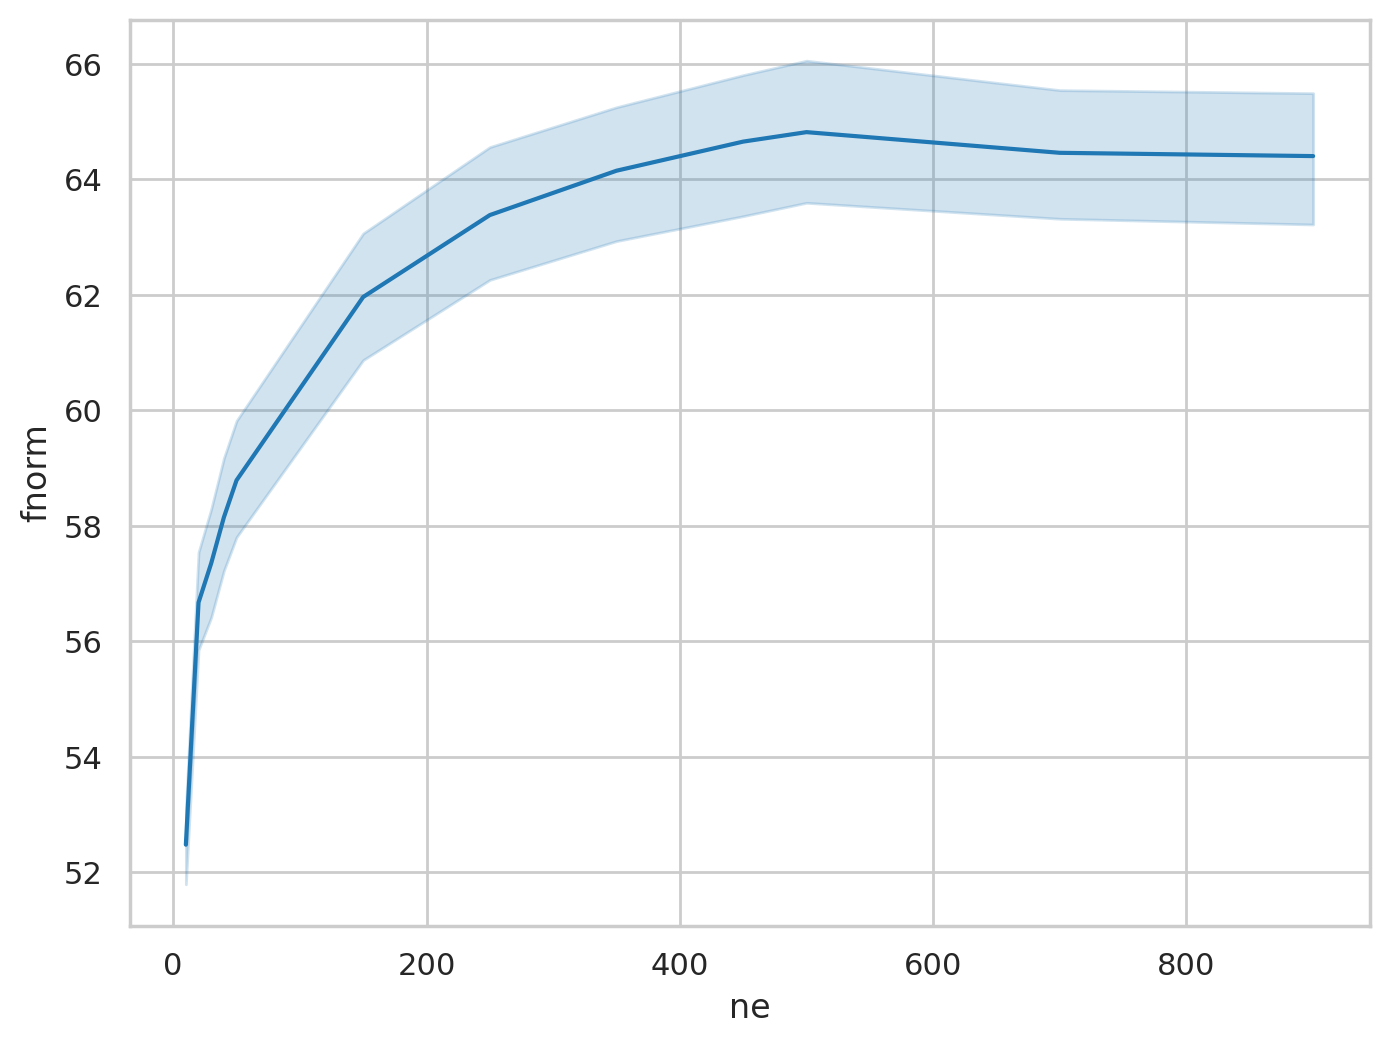

In [10]:
df = pd.DataFrame(avg_fnorm)
sns.lineplot(data=df, x='ne', y='fnorm')

## Distance to avg (dinpca)

In [66]:
dists = []
for s in np.concatenate([np.arange(0.01, 0.1, 0.05), np.arange(0.1, 1, 0.2)]):
# s = 0.1
    for k in ['yh']:
        for o in opts[:1]:
            for m in models[:1]:
                i1 = get_idx(dc, f"m=='{m}' & opt=='{o}' & avg==True")
                for seed in d['seed'].unique():
                    if seed < 0:
                        continue
                    i2 = get_idx(dc, f"m=='{m}' & opt=='{o}' & seed=={seed}")
                    di = dinpca(th.Tensor(r['xp'][i1]), th.Tensor(r['xp'][i2]), th.Tensor(np.sign(r['e'])))
                    p = th.exp(-di/(2*s)).sum(1)
                    kdist = (th.exp(-di/(2*s)) * dist).sum(1) / p
                    for i in range(N):
                        dists.append(dict(dist=kdist[i].item(), m=m, opt=o, 
                                          t=pts[i], key=k, seed=s, s=s))

Text(0.5, 1.0, 'distance to average model')

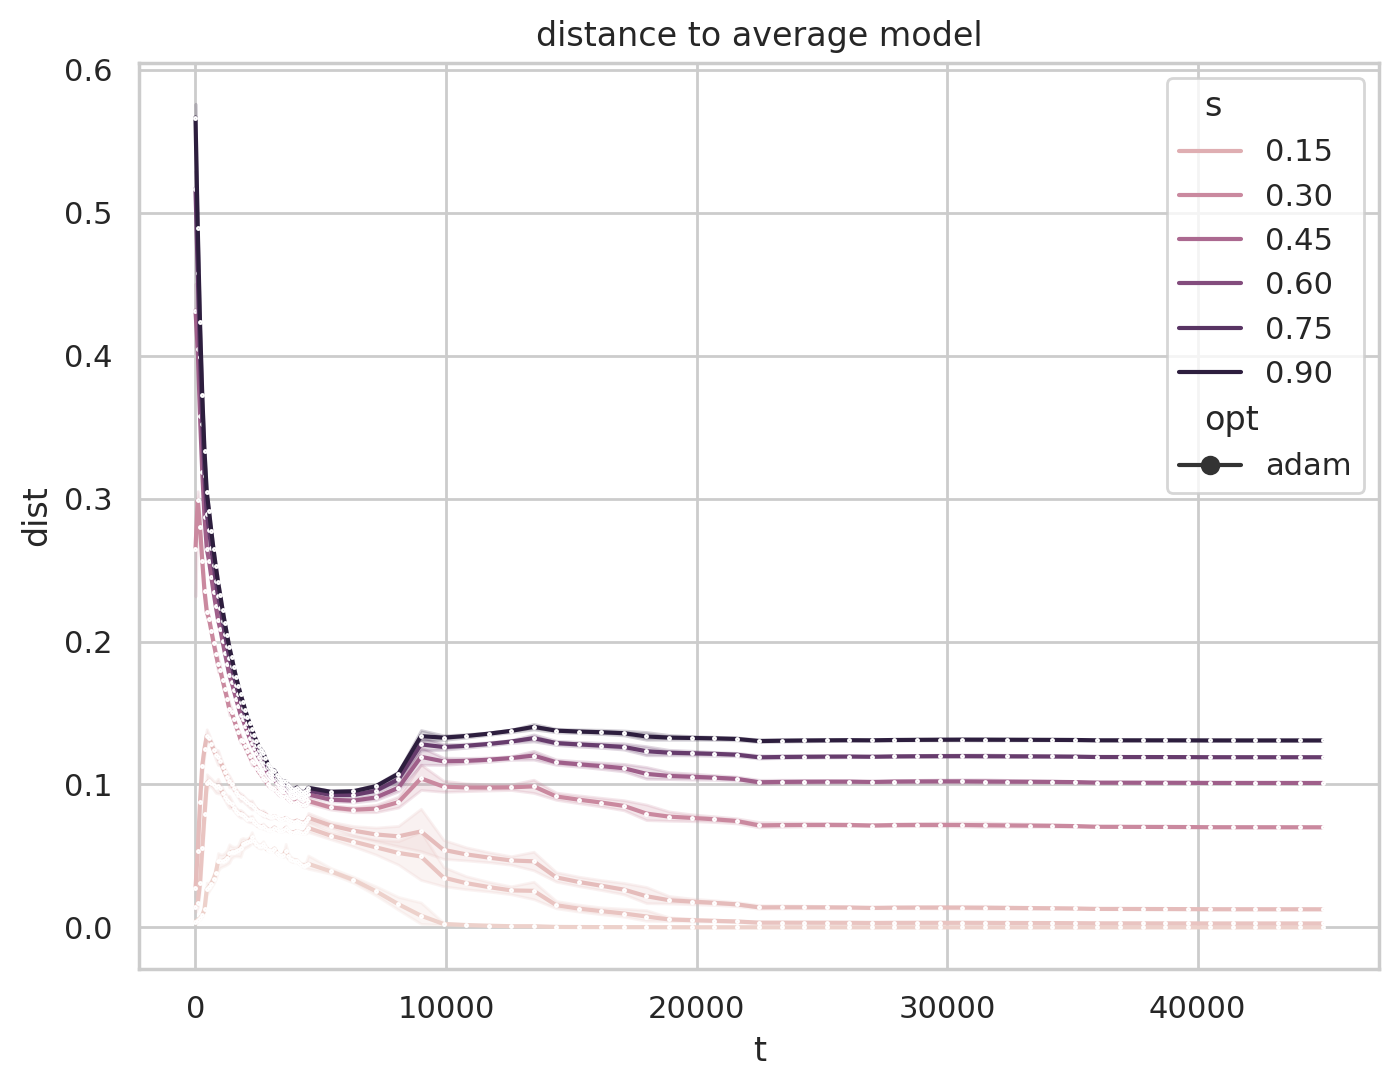

In [67]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"key=='yh'")], x='t', y='dist', hue='s', style='opt', markers=True, markersize=1)
ax.set_title('distance to average model')

In [68]:
dists = []

s = 0.1
for k in ['yh']:
    for o in opts:
        for m in models:
            i1 = get_idx(dc, f"m=='{m}' & opt=='{o}' & avg==True")
            for seed in d['seed'].unique():
                if seed < 0:
                    continue
                i2 = get_idx(dc, f"m=='{m}' & opt=='{o}' & seed=={seed}")
                di = dinpca(th.Tensor(r['xp'][i1]), th.Tensor(r['xp'][i2]), th.Tensor(np.sign(r['e'])))
                p = th.exp(-di/(2*s)).sum(1)
                kdist = (th.exp(-di/(2*s)) * dist).sum(1) / p
                for i in range(N):
                    dists.append(dict(dist=kdist[i].item(), m=m, opt=o, 
                                      t=pts[i], key=k, seed=s, s=s))

Text(0.5, 1.0, 'distance to average model')

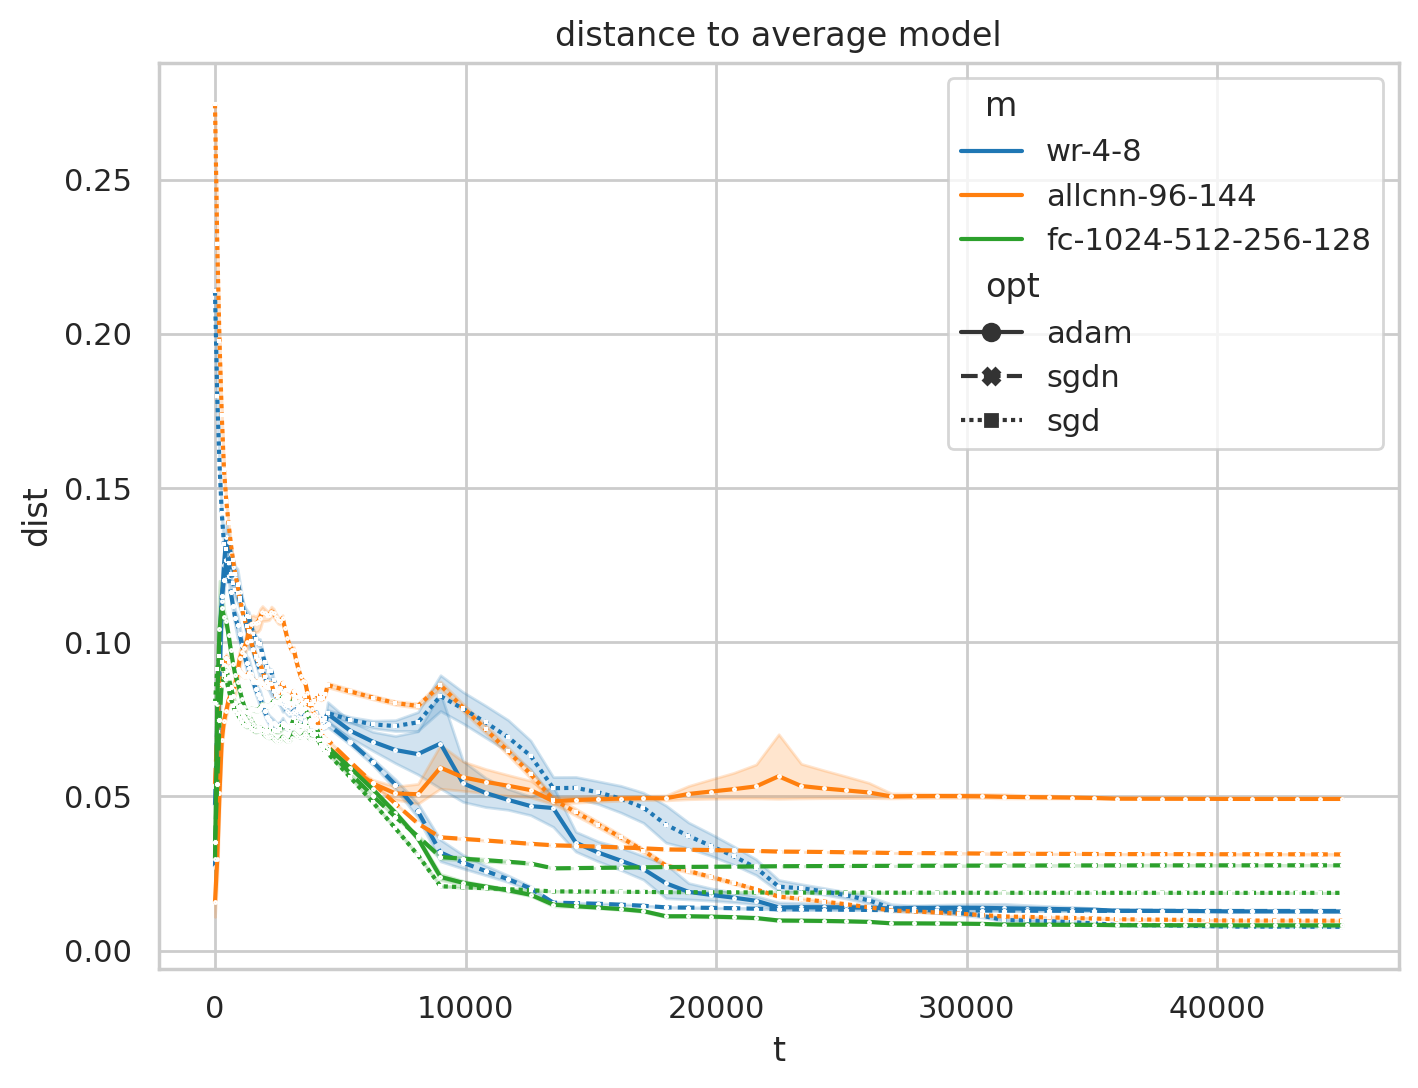

In [69]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"key=='yh'")], x='t', y='dist', hue='m', style='opt', markers=True, markersize=1)
ax.set_title('distance to average model')

In [127]:
dists = []
dts = th.Tensor((pts[1:] - pts[:-1]) / T).cuda()
for s in np.concatenate([np.arange(0.05, 0.1, 0.05), np.arange(0.1, 1, 0.2)]):
    k = 'yh'
    m = models[0]
    o = opts[0]
    i1 = get_idx(dc, f"m=='{m}' & opt=='{o}' & avg==True")
    for seed in d['seed'].unique():
        if seed < 0:
            continue
        i2 = get_idx(dc, f"m=='{m}' & opt=='{o}' & seed=={seed}")
        db = dbhat(th.Tensor(np.stack(d.iloc[i1][k])), th.Tensor(np.stack(d.iloc[i2][k])))[:, :-1]
        p = th.exp(-db/(2*s**2)).sum(1)
        kdist = (th.exp(-db/(2*s**2)) * db).sum(1) / p
#         kdist=dp2t(th.Tensor(np.stack(d.iloc[i1][k])), th.Tensor(np.stack(d.iloc[i2][k])), s=s)
        for i in range(len(kdist)):
            dists.append(dict(dist=kdist[i].item(), m=m, opt=o, 
                              t=pts[i], key=k, seed=seed, s=s))

Text(0.5, 1.0, 'dbhat weighted sum')

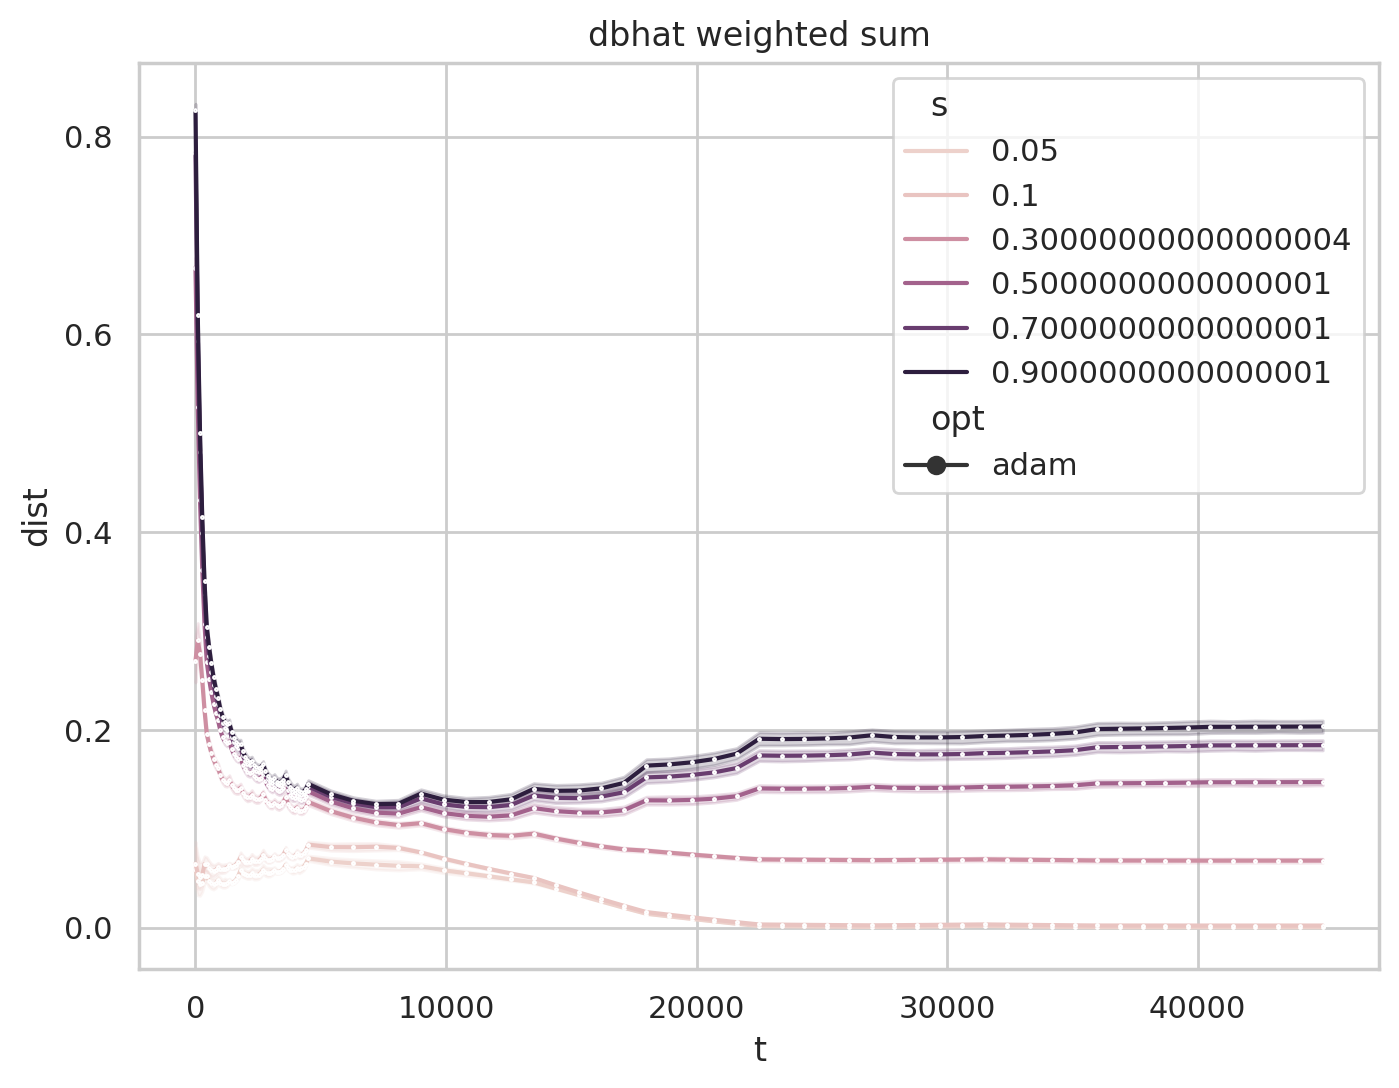

In [128]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"key=='yh'")], x='t', y='dist', hue='s', style='opt', markers=True, markersize=1)
ax.set_title('dbhat weighted sum')

Text(0.5, 1.0, 'dt & dbhat weighted sum')

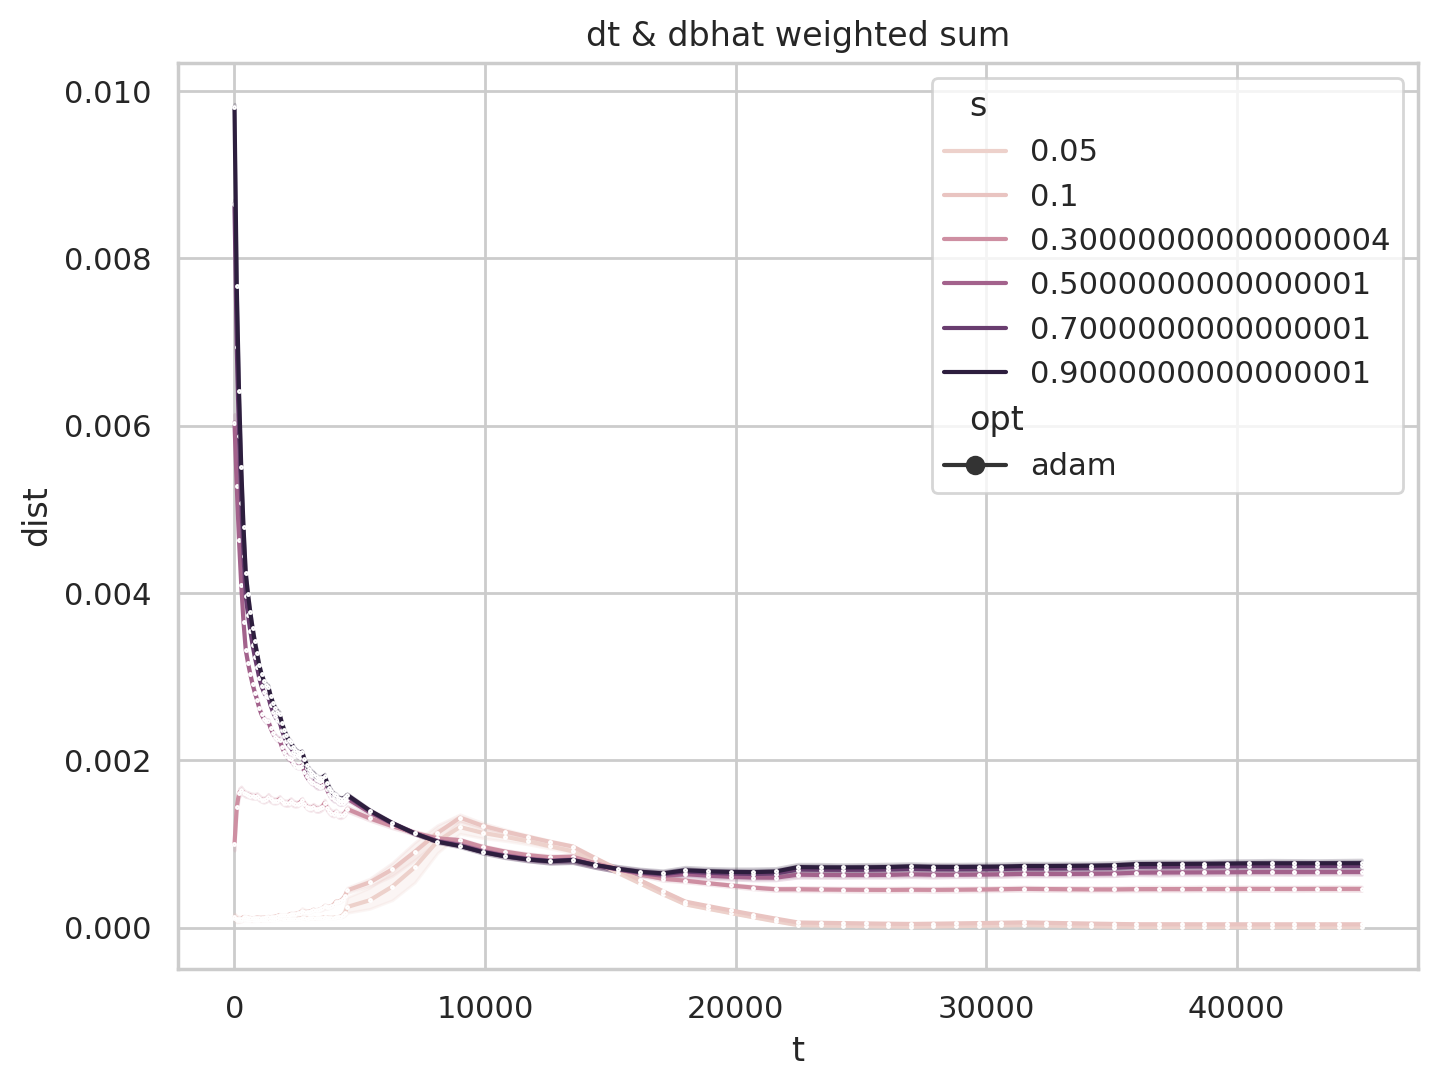

In [124]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"key=='yh'")], x='t', y='dist', hue='s', style='opt', markers=True, markersize=1)
ax.set_title('dt & dbhat weighted sum')

Text(0.5, 1.0, 'dy & dbhat weighted')

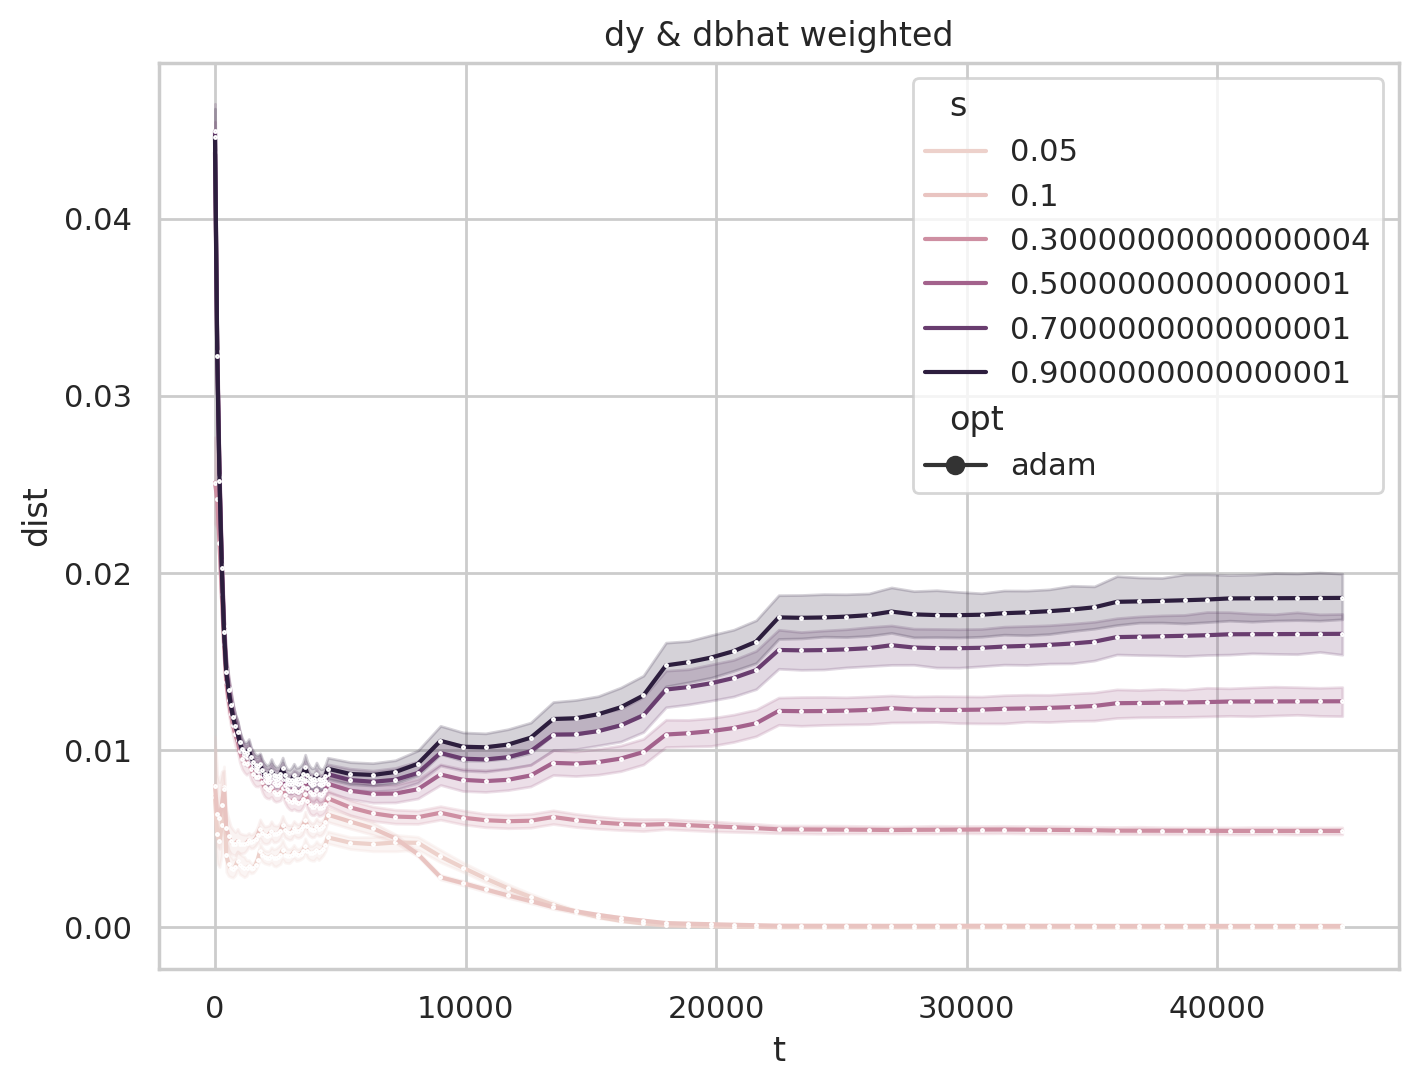

In [126]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"key=='yh'")], x='t', y='dist', hue='s', style='opt', markers=True, markersize=1)
ax.set_title('dy & dbhat weighted')

## Pairwise Distance

In [130]:
from utils import pairwise_dist
from distance import *
dists, configs = pairwise_dist(d, s=0.1)

In [145]:
dists_sym = (dists + dists.T)/2

In [156]:
idxs = []
columns = []
for (i, c) in enumerate(configs):
    if c[-1] != -1:
        idxs.append(i)
        columns.append(c[:2])
idxs = np.array(idxs)
columns = np.stack(columns)
cidxs = np.lexsort(columns.T)
idxs = idxs[cidxs]

didxs=dists_sym[:, idxs][idxs]

<AxesSubplot:>

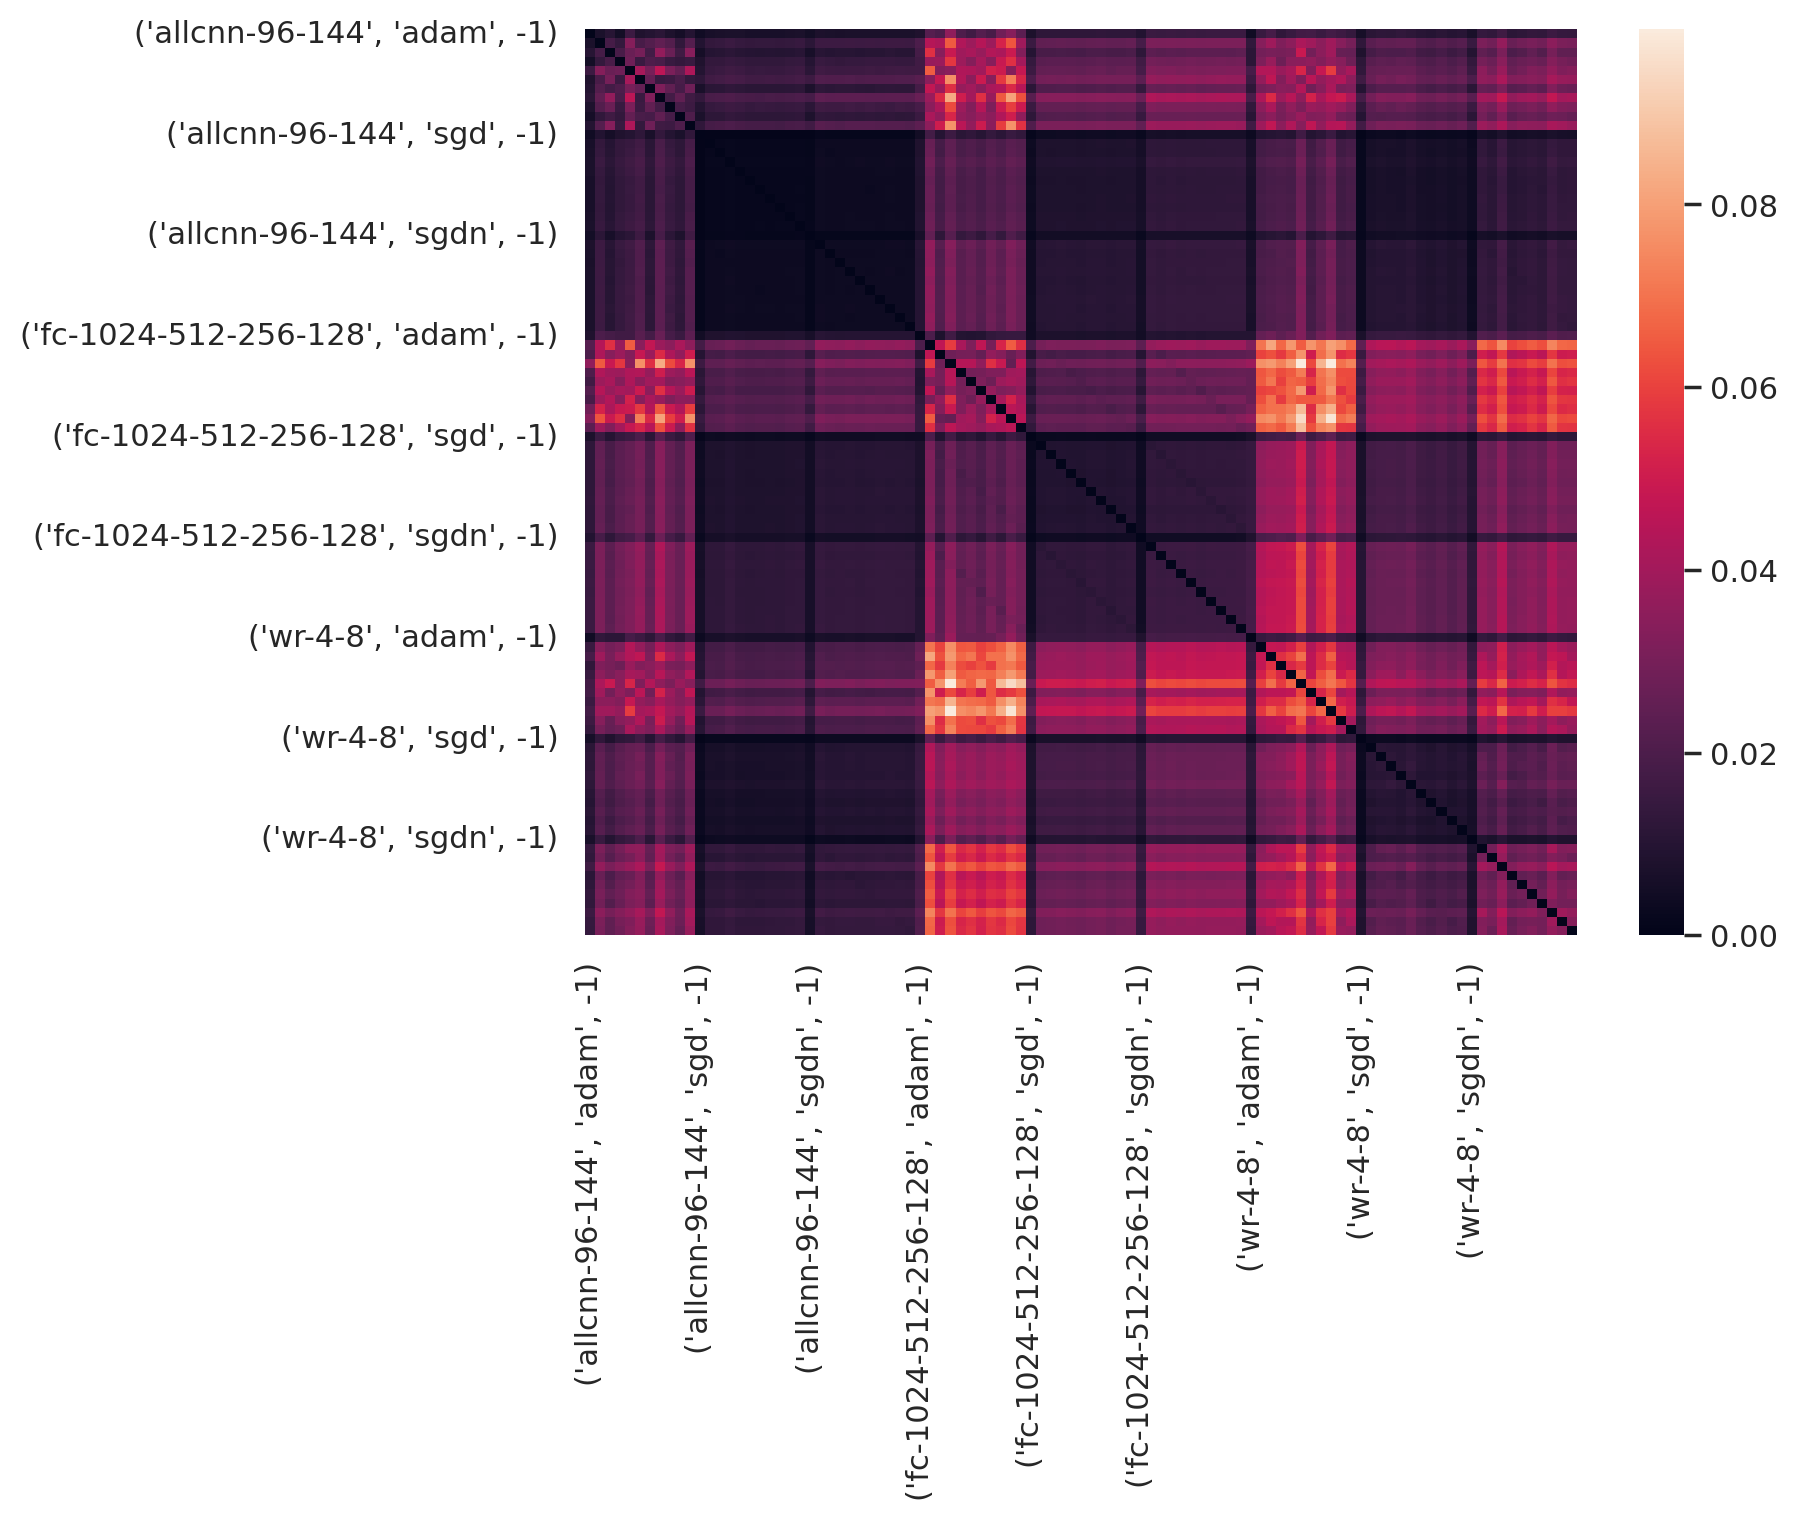

In [158]:
sns.heatmap(pd.DataFrame(dists_sym, columns=configs, index=configs), xticklabels=11, yticklabels=11)

<AxesSubplot:>

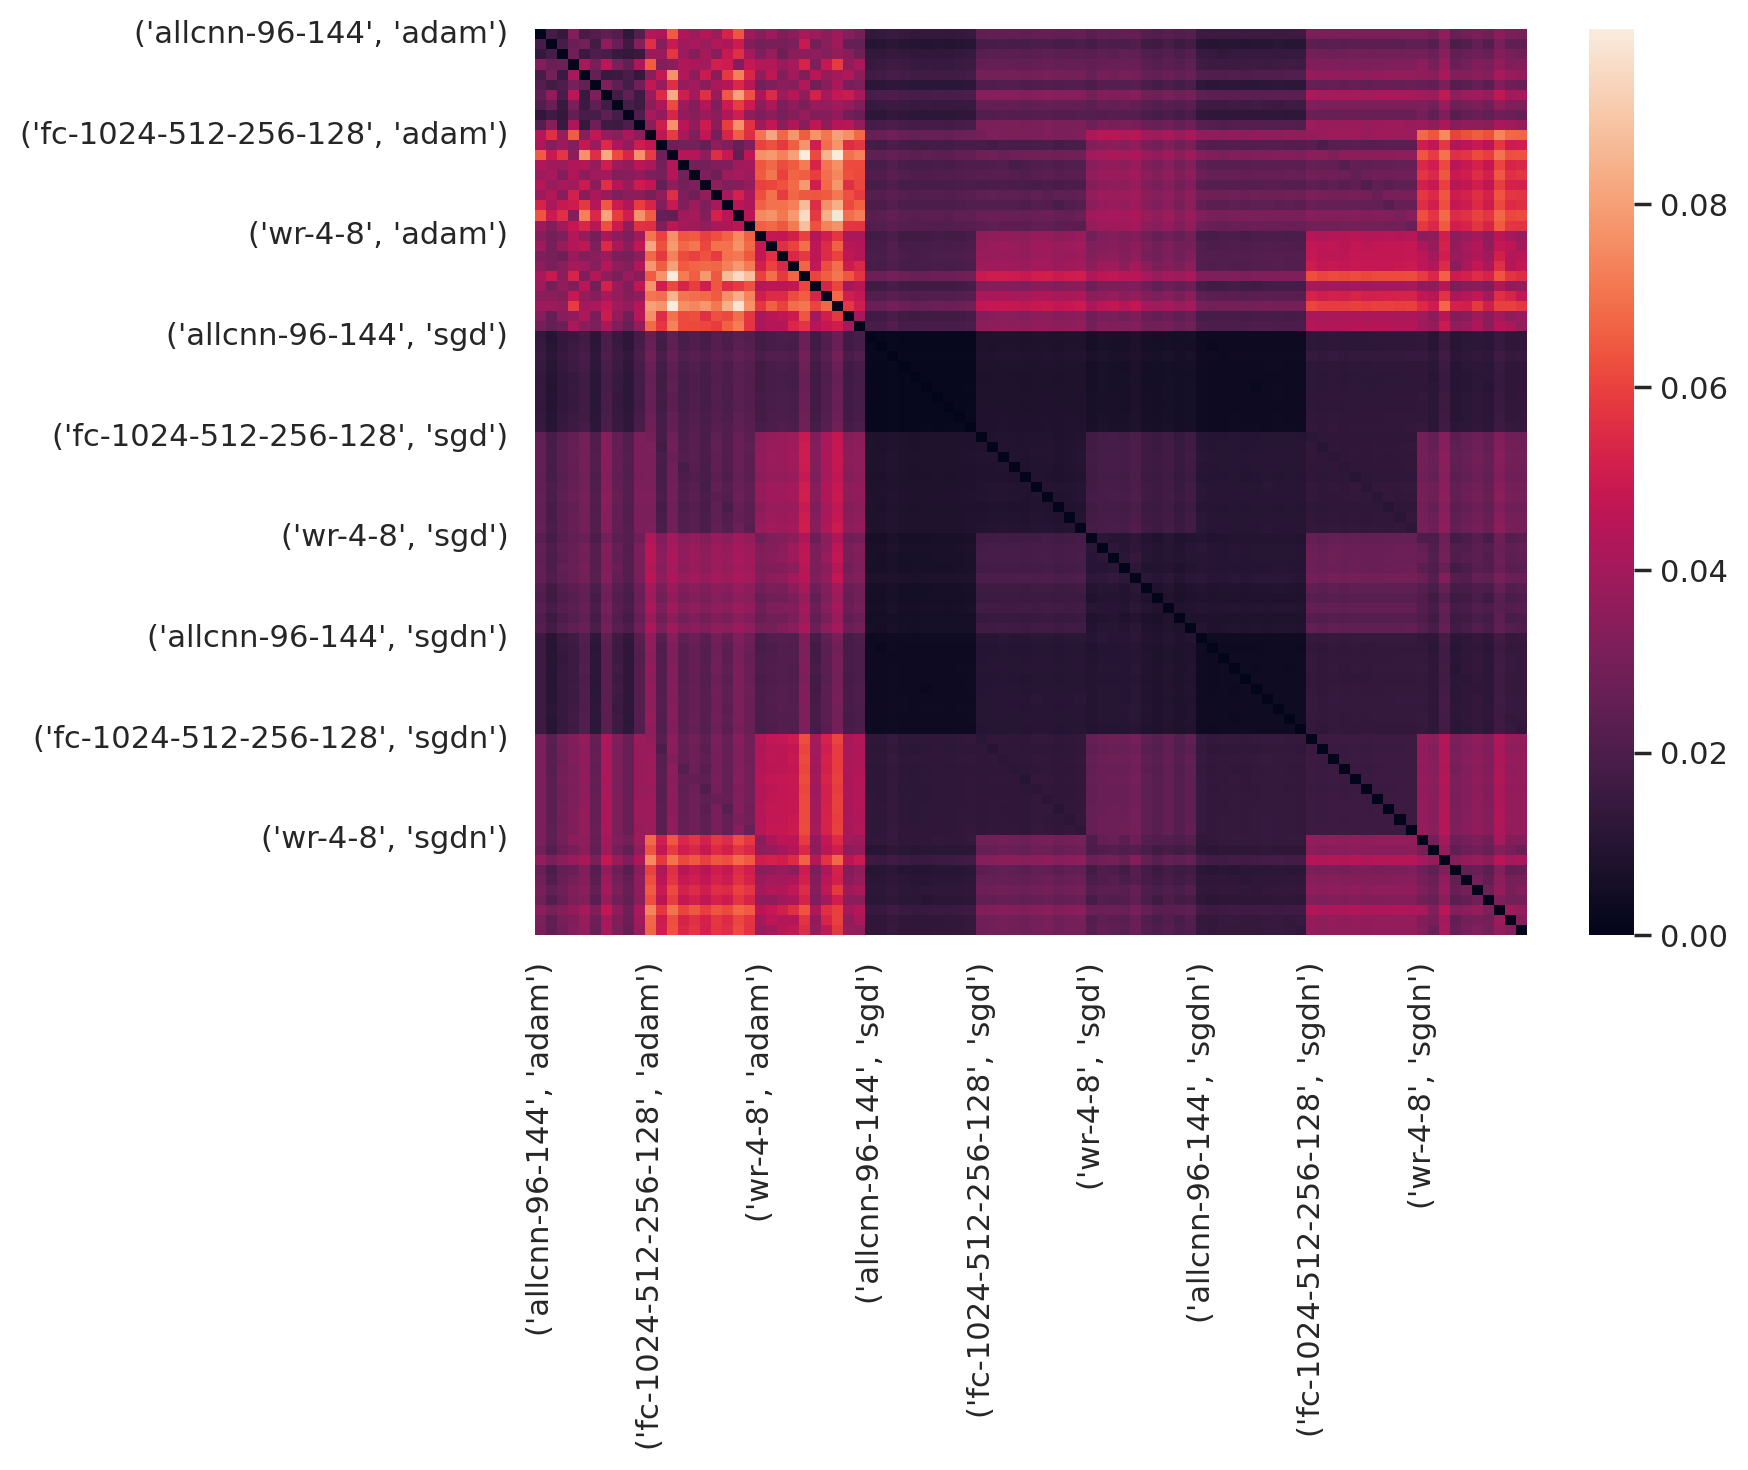

In [154]:
sns.heatmap(pd.DataFrame(didxs, columns=columns[cidxs], index=columns[cidxs]), xticklabels=10, yticklabels=10)

<AxesSubplot:>

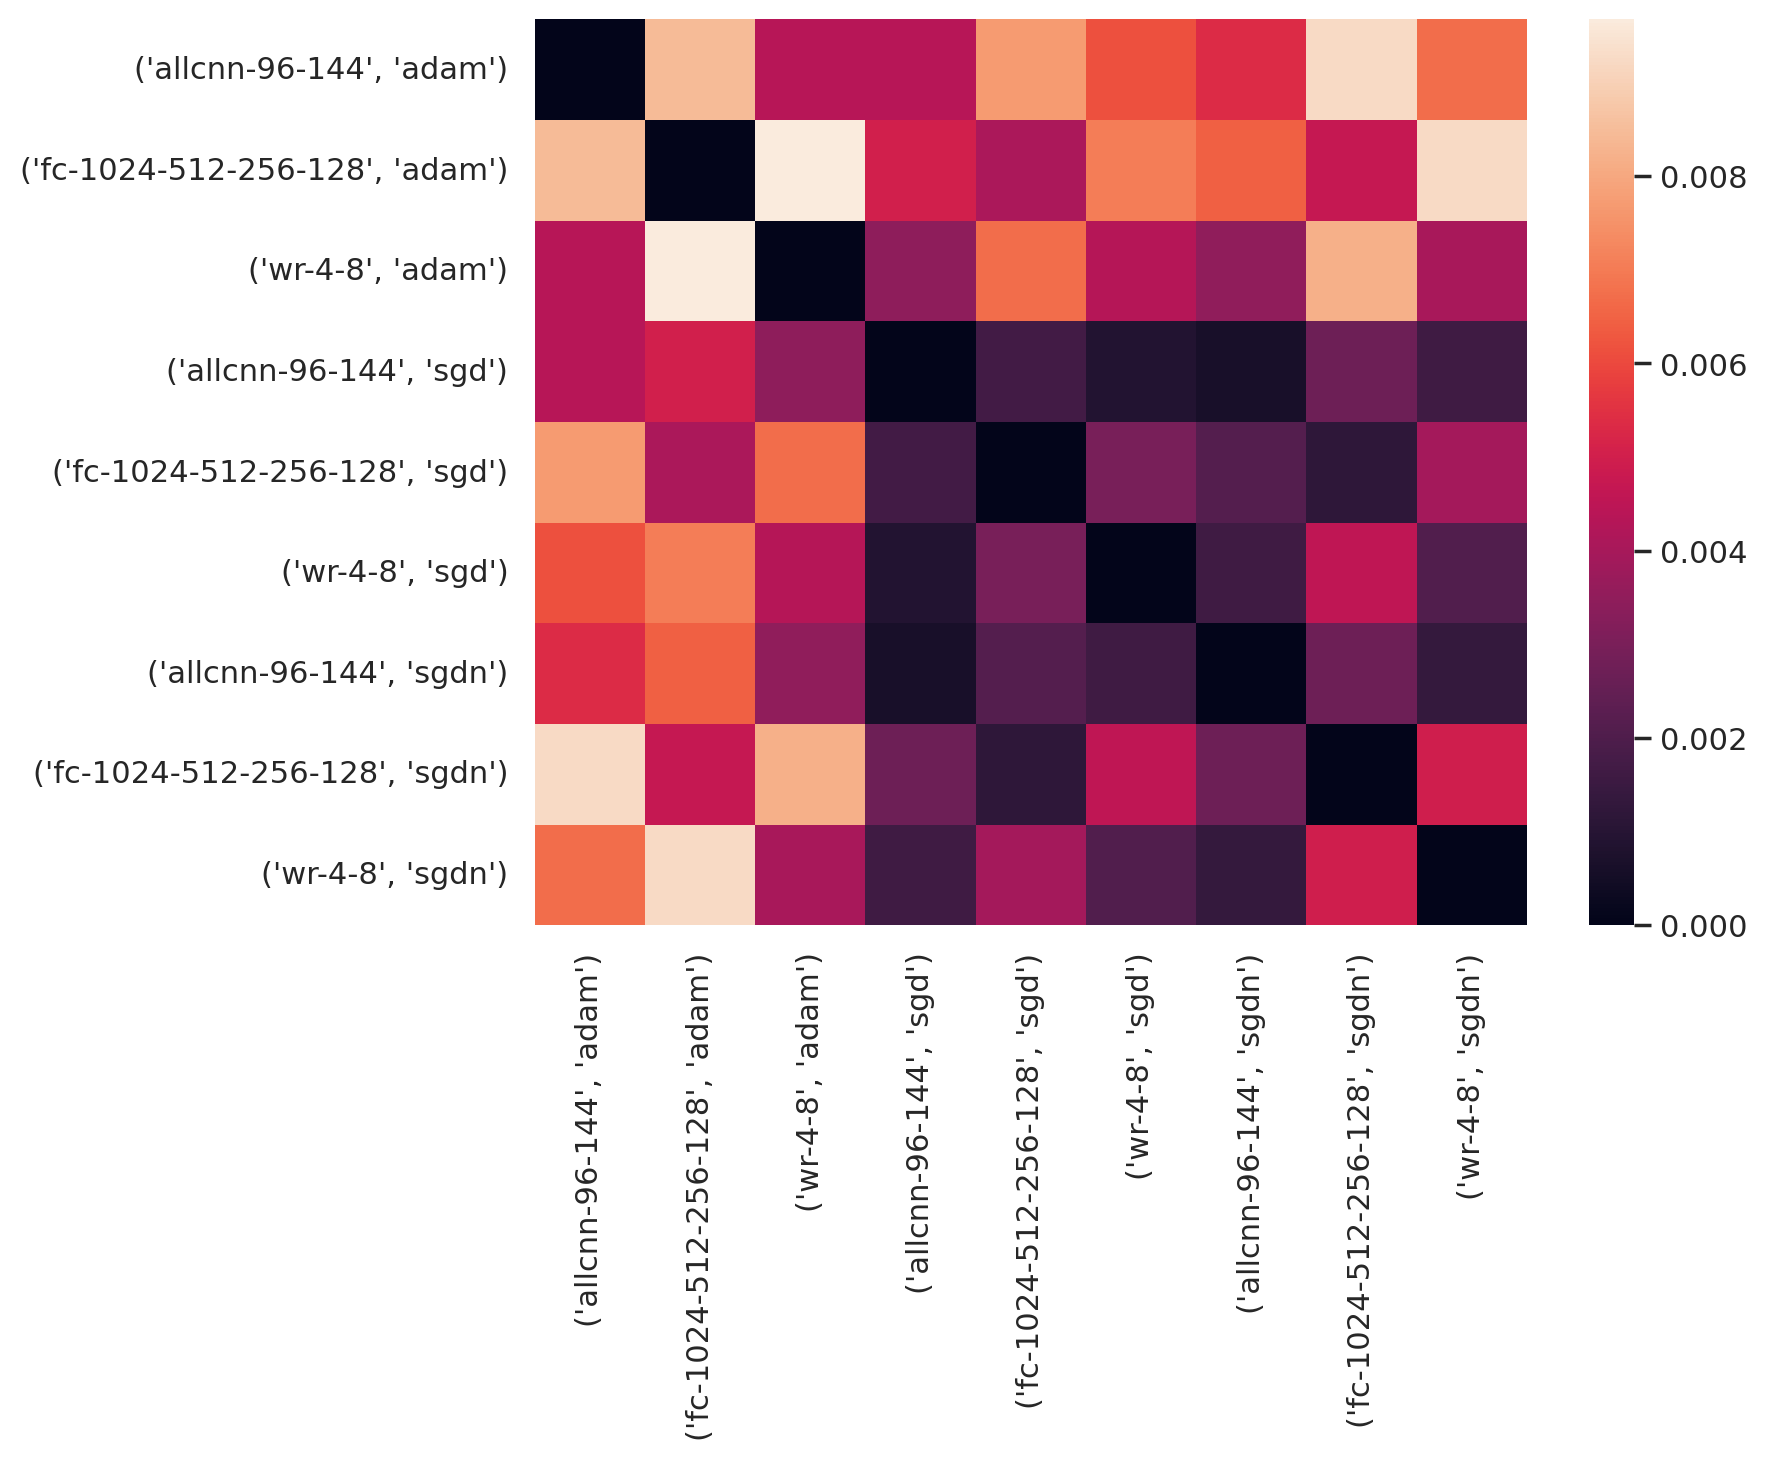

In [155]:
idxs = []
columns = []
for (i, c) in enumerate(configs):
    if c[-1] == -1:
        idxs.append(i)
        columns.append(c[:2])
idxs = np.array(idxs)
columns = np.stack(columns)
cidxs = np.lexsort(columns.T)
idxs = idxs[cidxs]

didxs=dists_sym[:, idxs][idxs]
sns.heatmap(pd.DataFrame(didxs, columns=columns[cidxs], index=columns[cidxs]), xticklabels=1, yticklabels=1)

In [89]:
data = []
d2 = np.arange(1, 11)
d1 = [22]
idxs = np.concatenate([d1, d2])
didxs=dists[:, :, idxs][:, idxs]
for t in range(len(didxs)):
    for (i, di) in enumerate(d1):
        for (j, dj) in enumerate(d2):
            d_ = didxs[t, i, len(d1)+j] + didxs[t, len(d1)+j, i]
            data.append(dict(t=t, label=(configs[di], configs[dj]), d=d_/2))
d2 = np.arange(22, 33)
d1 = [0]
idxs = np.concatenate([d1, d2])
didxs=dists[:, :, idxs][:, idxs]
for t in range(len(didxs)):
    for (i, di) in enumerate(d1):
        for (j, dj) in enumerate(d2):
            d_ = didxs[t, i, len(d1)+j] + didxs[t, len(d1)+j, i]
            data.append(dict(t=t, label=(configs[di], configs[dj]), d=d_/2))